# How to use this notebook
You should start by watching the [code walkthrough video](https://youtu.be/wdMk9F55_9A), which will explain the code in more detail and explain how to use it.

Throughout this notebook I will use pickle to save and load objects which take a long time to generate. [Read more about pickle](https://docs.python.org/3/library/pickle.html). This will save significant time by avoiding having to recreate these objects every time.

# Imports

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import pickle
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import math
import cv2
import requests

# Extract features from the images
In order to find the outliers in the image dataset, we first need to preprocess the data to be able to work well with the local outlier factor algorithm. To do this we will extract features from the images using a pretrained convolutional neural network. View [this tutorial](https://developers.google.com/machine-learning/practica/image-classification) for a hands on example of how convolutional neural networks work, and how we can use feature extraction.
## Initialize model
The pretrained model we will be using for feature extraction is [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function).

In [3]:
input_width = 224
input_height = 224
model = keras.applications.MobileNetV2(
    input_shape=(input_width, input_height, 3),
    include_top=False,
    weights='imagenet',
    pooling=None)

last_output = model.output
x = keras.layers.Flatten()(last_output)
model = keras.Model(model.input, x)

## Load images
Load all of the images and prepare them for feature extraction.

In [4]:
image_dir = 'flags/'
im_names = os.listdir(image_dir)
im_batch = []
im_ids = {}
count = 0
for im_name in im_names:
    im = Image.open(image_dir + im_name).convert('RGB').resize((input_width, input_height))
    np_im = np.array(im)
    im_batch.append(np_im)
    im_ids[count] = im_name
    count += 1

im_batch = np.array(im_batch)
im_batch = keras.applications.mobilenet_v2.preprocess_input(im_batch)

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Extract features
Depending on how many images you have and how much RAM you have, you may need to load the images and extract features in batches and then combine it later.

In [5]:
features = model.predict(im_batch, verbose=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


## Save features to file
Since it will probably take a decent amount of time to extract features for a large number of images, we want to avoid having to do this everytime we restart the notebook. In order to save objects to files I used pickle. [Read more about pickle here](https://docs.python.org/3/library/pickle.html). You only need to run this once, after you extracted the features for the first time. After this you should load the features from the pickle file.

In [6]:
with open('features.pkl', 'wb') as features_file:
    pickle.dump(features, features_file)

## Load features from file
If you have previously saved the features to a file using the previous cell, then you can now load them here whenever you restart the notebook

In [7]:
with open('features.pkl', 'rb') as features_file:
    features = pickle.load(features_file)

# Find outliers in features dataset
Now that we have extracted features from the images, we will use these features to find outliers in the dataset using the local outlier factor algorithm. See [more info](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html) and [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) on local outlier factor. We will also save and load these outlier scores since they will take a while to calculate.

In [8]:
lof = LocalOutlierFactor(n_jobs=-1)
feature_predictions = lof.fit_predict(features)
feature_scores = lof.negative_outlier_factor_

## Save feature outlier scores

In [9]:
with open('features_scores.pkl', 'wb') as features_scores_file:
    pickle.dump(feature_scores, features_scores_file)

## Load feature outlier scores

In [10]:
with open('features_scores.pkl', 'rb') as features_scores_file:
    feature_scores = pickle.load(features_scores_file)

# Extract histograms from images
While testing, I found that finding outliers in the dataset using only the features extracted from the neural network gave decent, but not great, results. The thing I noticed was that the images were lacking any interesting colors. To account for this I also decided to run the local outlier factor on color histograms of the images. This way, images with the highest outlier scores will now be ones with the most unique colors. [See more about color histograms](https://www.geeksforgeeks.org/python-opencv-cv2-calchist-method/).

In [11]:
image_dir = 'flags/'
im_names = os.listdir(image_dir)

histograms = []
count = 0
for im_name in im_names:
    im = cv2.imread(image_dir + im_name)
    hist = cv2.calcHist([im], [0, 1, 2], None, [10, 10, 10], [0, 256, 0, 256, 0, 256])
    histograms.append(hist.flatten()/np.sum(hist))
    count += 1

histograms = np.array(histograms)

## Save histograms

In [12]:
with open('histograms.pkl', 'wb') as hist_file:
    pickle.dump(histograms, hist_file)

## Load histograms

In [13]:
with open('histograms.pkl', 'rb') as hist_file:
    histograms = pickle.load(hist_file)

# Find outliers in histogram dataset
Just like before with the feature dataset, we will now find outliers in the histogram dataset.

In [14]:
lof = LocalOutlierFactor(n_jobs=-1)
histogram_predictions = lof.fit_predict(histograms)
histogram_scores = lof.negative_outlier_factor_

## Save histogram outlier scores

In [15]:
with open('histogram_scores.pkl', 'wb') as scores_file:
    pickle.dump(histogram_scores, scores_file)

## Load histogram outlier scores

In [16]:
with open('histogram_scores.pkl', 'rb') as histogram_scores_file:
    histogram_scores = pickle.load(histogram_scores_file)

# Sort images by outlier scores
We will now sort the images by the average outlier scores between the features dataset and histogram dataset. By finding the images with the highest average outlier scores between the two methods, it should provide us with images that have both interesting patterns (features dataset) and interesting colors (histogram dataset). From testing, this gave the best results, however, you can always experiment yourself and look at the images with the highest outlier scores from each individual dataset.
## Sort and rank feature outlier scores

In [17]:
feature_score_ids = {}
for i in range(len(feature_scores)):
    feature_score_ids[i] = feature_scores[i]

sorted_feature_scores = sorted(feature_score_ids.items(), key=lambda x: x[1], reverse=False)

feature_ranks = {}
for i, im_id in enumerate(sorted_feature_scores):
    feature_ranks[im_id[0]] = i

## Sort and rank histogram outlier scores

In [18]:
histogram_score_ids = {}
for i in range(len(histogram_scores)):
    histogram_score_ids[i] = histogram_scores[i]

sorted_histogram_scores = sorted(histogram_score_ids.items(), key=lambda x: x[1], reverse=False)

histogram_ranks = {}
for i, im_id in enumerate(sorted_histogram_scores):
    histogram_ranks[im_id[0]] = i

## Calculate average outlier rank for each image
Find the images with the highest average ranks and list the top 100 images. This will show the image ID with its average rank. You can use `im_ids` dictionary to get the image name from the image ID.

In [ ]:
avg_ranks = {}
for im_id in im_ids:
    avg_ranks[im_id] = (histogram_ranks[im_id] + feature_ranks[im_id])/2

sorted_ranks = sorted(avg_ranks.items(), key=lambda x: x[1], reverse=False)

## Display images with highest outlier scores
This will show the top 100 images with the highest outlier scores. You can adjust this by changing the `num_ims` variable.

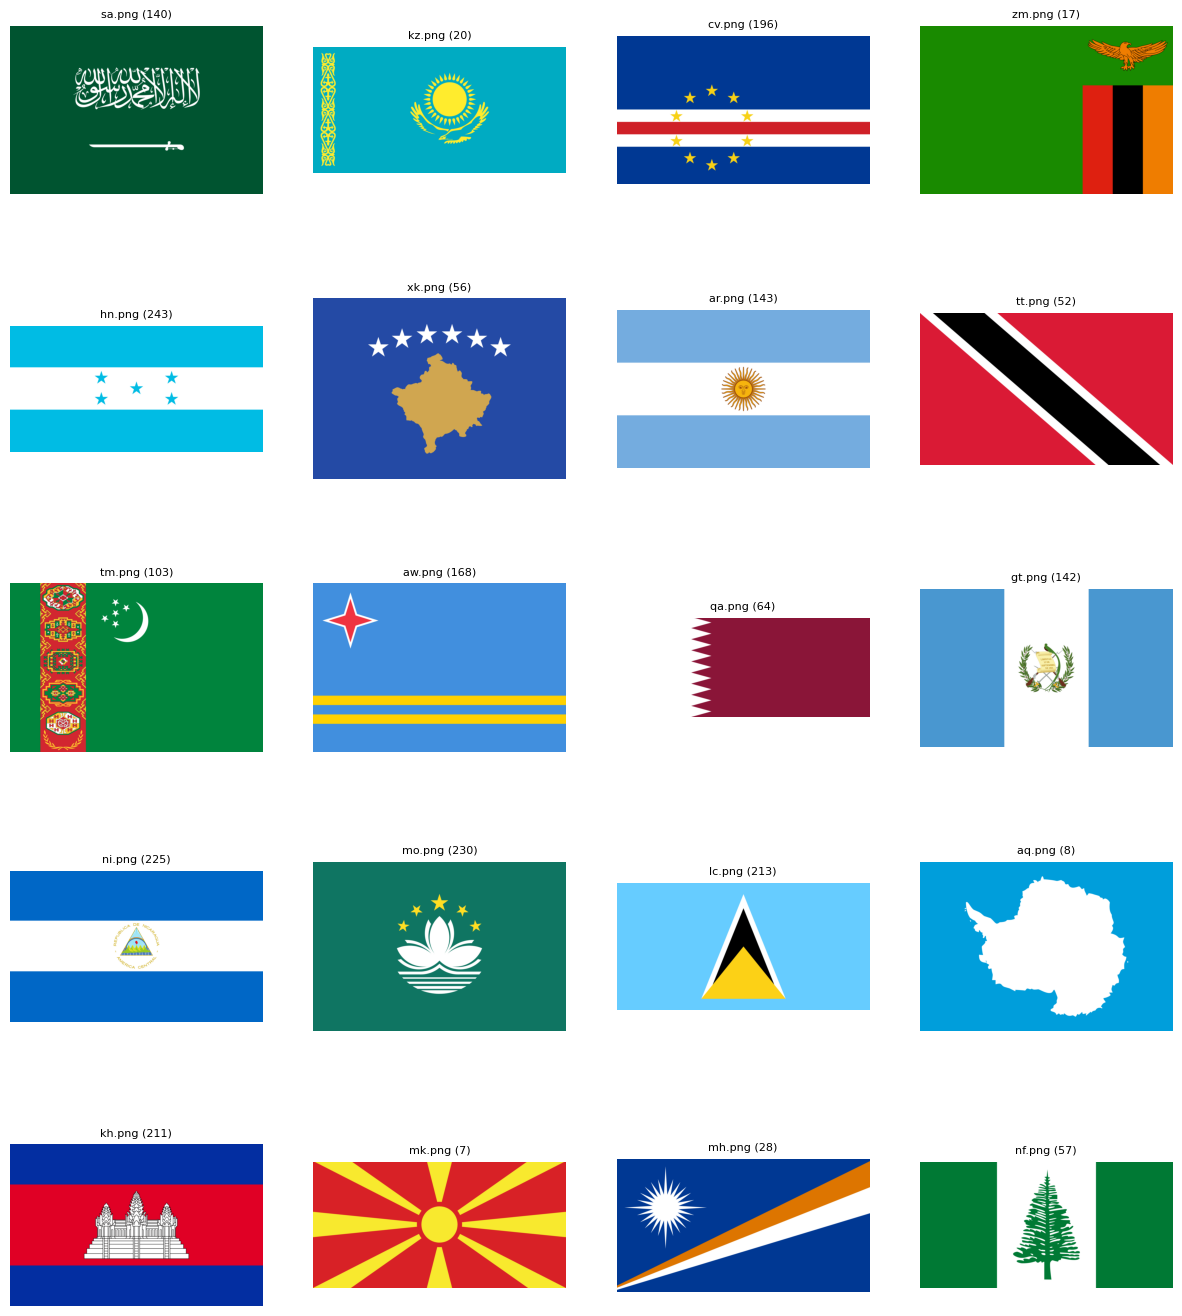

In [22]:
num_ims = 20
plt.figure(figsize=(15,math.ceil(num_ims/4)*3.5))
plt.subplots_adjust(hspace=0.2, wspace=0.2)
sim_labels = []

for i in range(num_ims):
    index = sorted_ranks[i][0]
    im = Image.open(image_dir + im_ids[index])
    plt.subplot(math.ceil(num_ims/4),4,i+1).set_title(f'{im_ids[index]} ({index})', fontsize=8)
    plt.imshow(im)
    plt.axis('off')